Safety can be roughly translated as the agent avoiding bad trajectories (state/action).

We aim at improving the policy, so that the output of the safety function, i.e. how quantifiably safe
is my current state and action pair, is as small as possible.

## Approach and artefacts

A seperate **Safety Controller** is used to advice the agent in critical states with action probabilities to ensure risk minimization. While the agent generally aims at accumelating the biggest expected return over a set of trajectories, the seperate Safety Controller network is aimed at advising the agent with actions. In the provided environment (LunarSafe-v0) we are given the values of risk measured by safety bounds, i.e. the vector between the coordinates of the Lander and predetermined boundaries. The Controller thereby modifies the optimizaiton criterion toward which the policy tends to converge, and the exploration process for the agent to include the notation of safety. 


The main function of the Safety Controller is to learn which states are unsafe, and which actions to take in proximity to those states. It learns the unsafe state in through a constraint given by the environment. 

## Bayesian Optimization

What we want to do is solve the safety function of the agent. We assume no knowledge of the inner workings of the agent and treat it as black box.

For the timing of the optimization, we have a few options:

1. The agent asks the controller **during training**. The benefit here being that the agent's safety is ensured at all time. The problem is that the Controller first needs to learn about the unsafe states.
2. The agent asks the controller **after training**. I was thinking about optimization here. But, the Controller's purpose is to ensure risk minimization by providing a measurement of safe an action is. 

Ressource: https://distill.pub/2020/bayesian-optimization/

## Normal training

In [12]:
import gym
import safe_agents as sa
import numpy as np
import skopt
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
env = gym.make('LunarSafe-v0')
n_states = env.observation_space.shape[0] - 2
n_actions = env.action_space.n

# Get memory from agent for training set
agent = sa.agents.DQNAgent(env, n_states, n_actions)
scores, bounds = agent.train(episodes=100)

episode: 0  | score: 38.53098896031494  | memory: 97 | epsilon: 0.9903464129058418

episode: 1  | score: -21.973959545862797  | memory: 162 | epsilon: 0.9839297172359803
episode: 2  | score: -301.09534923945535  | memory: 263 | epsilon: 0.9740415519716842
episode: 3  | score: -58.62124808952751  | memory: 391 | epsilon: 0.9616526587259188
episode: 4  | score: -12.33352875793922  | memory: 524 | epsilon: 0.948946724822904
episode: 5  | score: -84.0125953898876  | memory: 642 | epsilon: 0.937814406699894
episode: 6  | score: -192.76886964691062  | memory: 742 | epsilon: 0.9284825331684713
episode: 7  | score: -41.76556343313882  | memory: 872 | epsilon: 0.9164897823757778
episode: 8  | score: -91.51797936477422  | memory: 983 | epsilon: 0.9063724947491544
episode: 9  | score: -60.80422936599956  | memory: 1062 | epsilon: 0.8992400058381482
episode: 10  | score: 0.5457940533908499  | memory: 1182 | epsilon: 0.8885130796989219
episode: 11  | score: -29.98918301902748  | memory: 1293 | epsi

episode: 92  | score: -266.98858734879474  | memory: 10000 | epsilon: 0.24454145858067763
episode: 93  | score: 11.897471944457607  | memory: 10000 | epsilon: 0.24078010371096276
episode: 94  | score: -355.6484352601028  | memory: 10000 | epsilon: 0.2380268563703643
episode: 95  | score: -175.36185014583918  | memory: 10000 | epsilon: 0.23152367221925965
episode: 96  | score: 45.223549727306306  | memory: 10000 | epsilon: 0.22864749605830573
episode: 97  | score: 44.40314168185332  | memory: 10000 | epsilon: 0.22540094271724048
episode: 98  | score: 61.61005389879506  | memory: 10000 | epsilon: 0.21610808561115058
episode: 99  | score: -226.55103878183724  | memory: 10000 | epsilon: 0.19554170442493768


/usr/local/Caskroom/miniconda/base/envs/test-framework/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


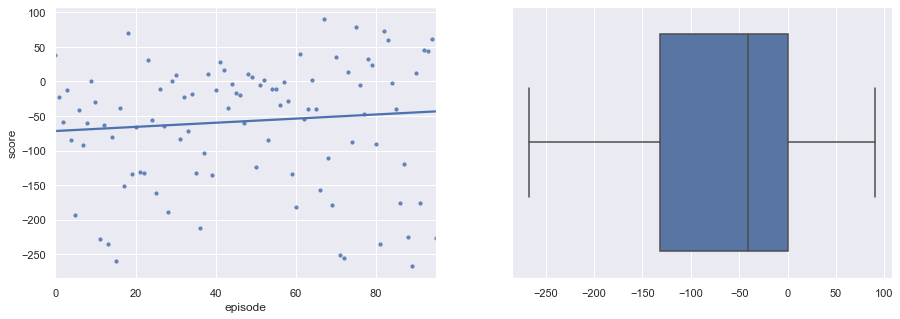

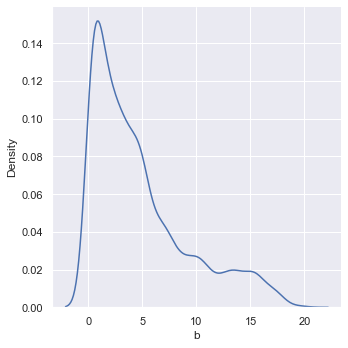

In [5]:
sa.utils.plot_visuals(agent, scores, bounds)

In [16]:
agent.memory

deque([(array([[0.0068182 , 1.49951635, 0.00382358, 0.14948047, 0.04396785,
                0.18149351, 0.        , 0.        ]]),
        0,
        1.4823291799096125,
        array([[0.0069479 , 1.50228597, 0.00379843, 0.12280431, 0.0530407 ,
                0.18147321, 0.        , 0.        ]]),
        False,
        array([[3.06947899, 2.93052101]])),
       (array([[0.0069479 , 1.50228597, 0.00379843, 0.12280431, 0.0530407 ,
                0.18147321, 0.        , 0.        ]]),
        2,
        -3.622734322105532,
        array([[ 0.00699701,  1.50553165, -0.00405971,  0.14391006,  0.06191789,
                 0.17754365,  0.        ,  0.        ]]),
        False,
        array([[3.06997013, 2.93002987]])),
       (array([[ 0.00699701,  1.50553165, -0.00405971,  0.14391006,  0.06191789,
                 0.17754365,  0.        ,  0.        ]]),
        0,
        1.513603567663239,
        array([[ 0.00704613,  1.50817853, -0.00405915,  0.1172368 ,  0.07079504,
              

## Safety Function

At each step, we get the current state, the next state, and the safety bounds values. Note that the safety bounds are only helpful for horizontal movement, i.e. is the Lander is within the bounds. An estimate for how well the agent is moving vertically is given be the reward _"[...] moving from top of the screen to the landing pad and zero speed is about 100-140 points"_. So we only need to care about horizontal movement.

$x^* = \arg min_{x} ($
    
    
Question: how the fuck did I define the bounds? what are those values. they can't be right. State[0] is different than b1,b2

  
```  
s (list): The state. Attributes:
s[0] is the horizontal coordinate
s[1] is the vertical coordinate
s[2] is the horizontal speed
s[3] is the vertical speed
s[4] is the angle
s[5] is the angular speed
s[6] 1 if first leg has contact, else 0
s[7] 1 if second leg has contact, else 0

```

Zwei Vektoren

```
# Für links
p1 = (pos.x, pos.y)
p2 = ((self.helipad_x1 - VIEWPORT_W/2/10/SCALE), pos.y)
v1 = (pos.x - (self.helipad_x1 - VIEWPORT_W/2/10/SCALE), pos.y)

# Für rechts
p1 = (pos.x, pos.y)
p2 = ((self.helipad_x2 + VIEWPORT_W/2/10/SCALE), pos.y)
v2 = (pos.x - (self.helipad_x1 + VIEWPORT_W/2/10/SCALE), pos.y)

mittelpunkt = v1 - v2
mittelpunkt = ((pos.x - (self.helipad_x1 - VIEWPORT_W/2/10/SCALE), pos.y), (pos.x - (self.helipad_x1 + VIEWPORT_W/2/10/SCALE), pos.y))
```

In [15]:
noise_level = 0.1

def safety_func(x, noise_level=noise_level):
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2))+ np.random.randn() * noise_level

x = np.linspace(-2, 2, 400).reshape(-1, 1)
fx = [safety_func(x_i, noise_level=0.0) for x_i in x]

fx

[0.0003648751010265424,
 0.00036421223666233815,
 0.0003597733052662445,
 0.0003509804774107912,
 0.0003372065643243921,
 0.00031777348010165996,
 0.000291950955175524,
 0.0002589555471380062,
 0.00021794999817574204,
 0.0001680429914818202,
 0.0001082893619733421,
 3.769081943515142e-05,
 -4.480275522157838e-05,
 -0.0001402913776115492,
 -0.00024992232651493035,
 -0.0003748867430326728,
 -0.0005164153947024017,
 -0.0006757735364691467,
 -0.000854254800457513,
 -0.0010531740472204739,
 -0.0012738591126174477,
 -0.0015176413867759545,
 -0.0017858451647932566,
 -0.0020797757130065755,
 -0.0024007059998828136,
 -0.0027498620469113286,
 -0.0031284068624022354,
 -0.003537422929851427,
 -0.003977893232590894,
 -0.004450680807846183,
 -0.0049565068361098145,
 -0.005495927285937387,
 -0.00606930814990027,
 -0.006676799324485623,
 -0.007318307205208204,
 -0.007993466088060444,
 -0.008701608489628159,
 -0.009441734520667683,
 -0.010212480471590634,
 -0.01101208679301619,
 -0.011838365680188718,


In [24]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# state = v_speed, l_bound, bound

def safety_critic(state_size, action_size, learning_rate=0.0001):
    model = Sequential()
    model.add(Dense(64, input_dim=state_size, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(action_size, activation='linear', kernel_initializer='he_uniform'))
    #model.summary()
    model.compile(loss='mse', optimizer=Adam(lr=learning_rate))
    return model




In [28]:
[abs(b[0])-abs(b[1]) for b in (bounds)]


[0.13895797729492188,
 0.1399402618408203,
 0.14092254638671875,
 0.14257049560546875,
 0.1447124481201172,
 0.14685440063476562,
 0.15024375915527344,
 0.1543140411376953,
 0.15412330627441406,
 0.14975357055664062,
 0.14356231689453125,
 0.13736724853515625,
 0.13265037536621094,
 0.12341880798339844,
 0.11584854125976562,
 0.10848045349121094,
 0.10258865356445312,
 0.09597587585449219,
 0.08918571472167969,
 0.08434104919433594,
 0.07836151123046875,
 0.06978988647460938,
 0.06264114379882812,
 0.05394172668457031,
 0.04712867736816406,
 0.0417022705078125,
 0.03485679626464844,
 0.029581069946289062,
 0.022674560546875,
 0.017475128173828125,
 0.010980606079101562,
 0.001331329345703125,
 -0.0065155029296875,
 -0.017444610595703125,
 -0.029851913452148438,
 -0.04297828674316406,
 -0.05610466003417969,
 -0.07334709167480469,
 -0.08879280090332031,
 -0.10786628723144531,
 -0.12937545776367188,
 -0.14901161193847656,
 -0.169189453125,
 -0.18936729431152344,
 -0.21021461486816406,
 -0